# The Lyapunov spectrum of the Lorenz system

Here, we present a calculation of the Lyapunov spectrum of the Lorenz system, using `TaylorIntegration.jl`. Our calculation involves evaluating the 1st order variational equations $\dot \xi = J \cdot \xi$ for this system, where $J = \operatorname{D}f$ is the Jacobian. By default, the numerical value of the Jacobian is computed using automatic differentiation techniques implemented in `TaylorSeries.jl`. Automatic differentation helps us to avoid writing down manually the Jacobian; instead, `TaylorIntegration.jl` does that for us! For complex problems, or when the number of dependent variables is large, this may help save typos, which sometimes are hard to trace. Otherwise, if performance is critical, then the user may provide the Jacobian function, as will be shown below.

The Lorenz system is the ODE defined as:

$$
\begin{align}
    \begin{split}
    \dot x_1 &= \sigma(x_2-x_1) \\
    \dot x_2 &= x_1(\rho-x_3)-x_2 \\
    \dot x_3 &= x_1x_2-\beta x_3 
    \end{split}
\end{align}
$$

where $\sigma$, $\rho$ and $\beta$ are constant parameters.

## The setup

First, we write a Julia function which evaluates (in-place) the Lorenz system equations:

In [1]:
#Lorenz system ODE:
function lorenz!(t, x, dx)
    dx[1] = σ*(x[2]-x[1])
    dx[2] = x[1]*(ρ-x[3])-x[2]
    dx[3] = x[1]*x[2]-β*x[3]
    nothing
end

lorenz! (generic function with 1 method)

Next, we define the parameters:

In [2]:
#Lorenz system parameters
#we use the `const` prefix in order to help the compiler speed things up
const σ = 16.0
const β = 4.0
const ρ = 45.92

45.92

The initial conditions, the initial and final time are:

In [3]:
const x0 = [19.0, 20.0, 50.0] #the initial condition
const t0 = 0.0 #the initial time
const tmax = 100.0 #final time of integration

100.0

We know that the sum of the Lyapunov spectrum has to be equal to the trace of the Jacobian of the equations of motion. We will calculate this trace using `TaylorSeries.jl`, and after the numerical integration, we will come back to this value to check that this is indeed the case:

In [4]:
# Note that TaylorSeries.jl exported variables and methods are @reexport-ed by TaylorIntegration.jl
#Calculate trace of Lorenz system Jacobian via TaylorSeries.jacobian:
import LinearAlgebra: tr
using TaylorIntegration
xi = set_variables("δ", order=1, numvars=length(x0))
x0TN = [ x0[1]+xi[1], x0[2]+xi[2], x0[3]+xi[3] ]
dx0TN = similar(x0TN)
lorenz!(t0, x0TN, dx0TN)
lorenztr = tr(TaylorSeries.jacobian(dx0TN)) #trace of Lorenz system Jacobian matrix

-21.0

# The integration

Now, we are ready to perform the integration, using `TaylorIntegration.jl`. Usually, we would use the `taylorinteg` method in order to integrate the equations of motion; but, since we are interested in evaluating the Lyapunov spectrum, we will use the `lyap_taylorinteg` method, which calculates the Lyapunov spectrum via the variational equations and Oseledets' theorem. The expansion order will be $28$; the local absolute tolerance will be $10^{-20}$. `lyap_taylorinteg` will return three arrays: one with the evaluation times, one with the value of the dependent variables at the time of evaluation, and another one with the vaues of the Lyapunov spectrum at each time of the evaluation.

In [5]:
@time tv, xv, λv = lyap_taylorinteg(lorenz!, x0, t0, tmax, 28, 1e-20; maxsteps=2000000);

  3.038651 seconds (15.28 M allocations: 1.371 GiB, 13.00% gc time)


As explained above, instead of using automatic differentiation to compute the numerical value of the Jacobian, the user may provide a function which computes the Jacobian in-place, as follows:

In [6]:
#Lorenz system Jacobian (in-place):
function lorenz_jac!(jac, t, x)
    jac[1,1] = -σ+zero(x[1]); jac[1,2] = σ+zero(x[1]); jac[1,3] = zero(x[1])
    jac[2,1] = ρ-x[3]; jac[2,2] = -1.0+zero(x[1]); jac[2,3] = -x[1]
    jac[3,1] = x[2]; jac[3,2] = x[1]; jac[3,3] = -β+zero(x[1])
    nothing
end

lorenz_jac! (generic function with 1 method)

Then, we may perform the same integration as before using `lorenz_jac!`:

In [7]:
@time tv_, xv_, λv_ = lyap_taylorinteg(lorenz!, x0, t0, tmax, 28, 1e-20, lorenz_jac!; maxsteps=2000000);

  0.856854 seconds (4.35 M allocations: 575.767 MiB, 20.75% gc time)


In general, we may check the consistency of our integration checking that both solutions are either equal, or at least approximately equal with differences comparable to roundoff errors. In the particular case of the integrations performed above, we obtain the same solution, *exactly*:

In [8]:
tv == tv_, xv == xv_, λv == λv_

(true, true, true)

The number of steps taken is:

In [9]:
length(tv)

4093

Is the final time actually the requested value?

In [10]:
tv[end] == tmax

true

What is the minimum, maximum and mean time-step?

In [11]:
import Statistics: mean
minimum(diff(tv)), maximum(diff(tv)), mean(diff(tv))

(0.009471209659452029, 0.0608034582365633, 0.024437927663734114)

What is the standard deviation of the time-step size distribution?

In [12]:
import Statistics: std
std(diff(tv))

0.007428238447533755

What is the final value for each of the exponents?

In [13]:
λv[end,:]

3-element Array{Float64,1}:
   1.4856676067102397   
  -0.0012149610701265275
 -22.484452645640157    

What is the value of the sum of the value we obtained for the spectrum?

In [14]:
sum(λv[end,:])

-21.000000000000043

Now, is the sum of the exponents exactly equal to the trace of the Jacobian?

In [15]:
sum(λv[end,:]) == lorenztr

false

So the sum is not *exactly* equal, but is it approximately equal? What is the relative error in the computed vs the expected value?

In [16]:
rel_error = (sum(λv[end,:])-lorenztr)/lorenztr

2.0301221021717147e-15

How does this error compare to the machine epsilon?

In [17]:
rel_error/eps()

9.142857142857142

So the relative error in our computation for the sum of the Lyapunov spectrum is comparable to the machine epsilon.

# Visualization

Finally, we plot our results:

In [18]:
using Plots
#gr()
#using LaTeXStrings
#plotlyjs()

### Lyapunov exponents vs time plot

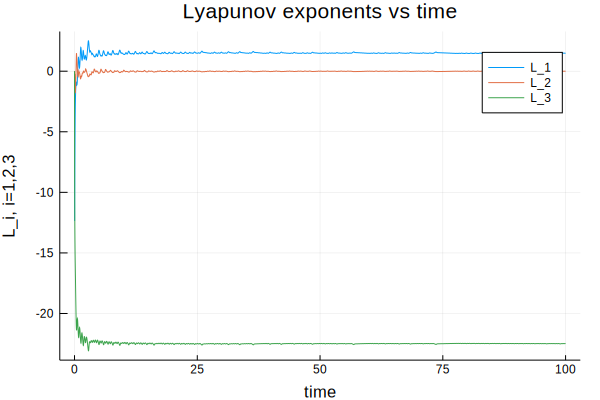

In [19]:
plot(tv, λv[:,1], label="L_1")
plot!(tv, λv[:,2], label="L_2")
plot!(tv, λv[:,3], label="L_3")
xlabel!("time")
ylabel!("L_i, i=1,2,3")
title!("Lyapunov exponents vs time")

### Lyapunov exponents vs time plot (semi-log)

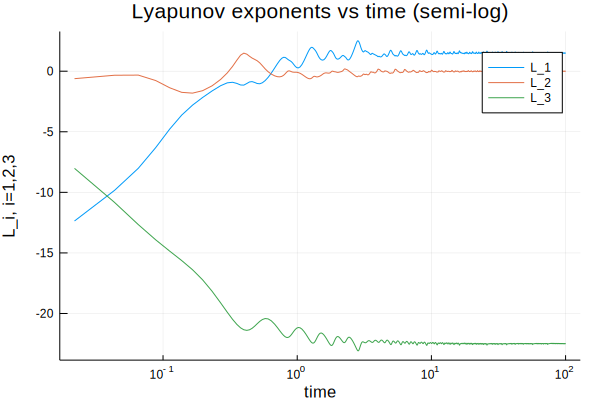

In [20]:
plot(tv[2:end], λv[:,1][2:end], xscale=:log10, label="L_1")
plot!(tv[2:end], λv[:,2][2:end], label="L_2")
plot!(tv[2:end], λv[:,3][2:end], label="L_3")
xlabel!("time")
ylabel!("L_i, i=1,2,3")
title!("Lyapunov exponents vs time (semi-log)")

### Convergence of Lyapunov exponents vs time plot (log-log)

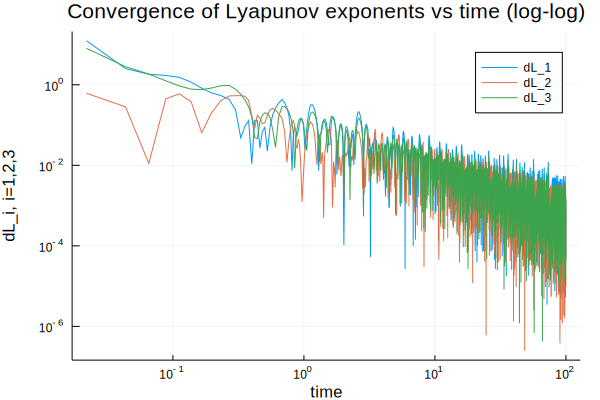

In [21]:
plot(tv[2:end], abs.(diff(λv[:,1])), yscale=:log10, xscale=:log10, label="dL_1")
plot!(tv[2:end], abs.(diff(λv[:,2])), label="dL_2")
plot!(tv[2:end], abs.(diff(λv[:,3])), label="dL_3")
xlabel!("time")
ylabel!("dL_i, i=1,2,3")
title!("Convergence of Lyapunov exponents vs time (log-log)")

### Absolute difference wrt trace of Jacobian vs time plot (log-log)

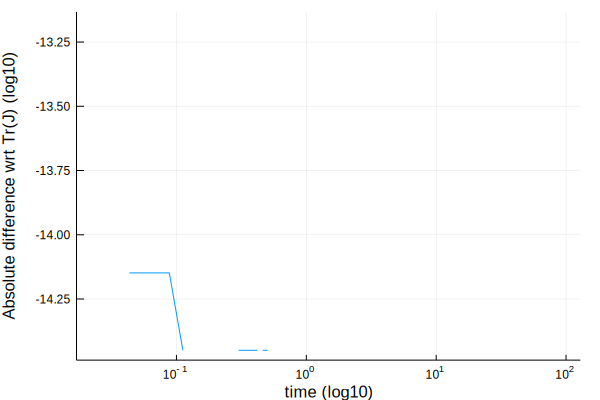

In [22]:
plot(tv[2:end], log10.(abs.(λv[2:end,1]+λv[2:end,2]+λv[2:end,3].-lorenztr)), xscale=:log10, leg=false)
#ylims!(-15,-12)
xlabel!("time (log10)")
ylabel!("Absolute difference wrt Tr(J) (log10)")

## The Lorenz attractor

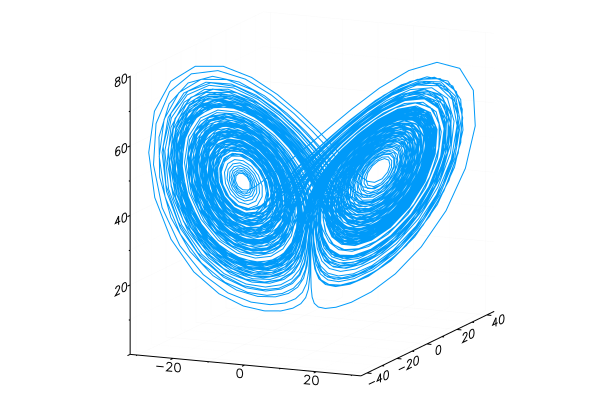

In [23]:
plot(xv[:,1], xv[:,2], xv[:,3], leg=false)